## Import Packages


In [ ]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import csv
import random
import keras

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

## Mount Drive & Load Data

In [ ]:
#mount drive
from google.colab import drive

# Trevor when running this make sure you do
# Go to "Shared with me"
# Right click the CS528_Final_Project
# Click organize, add shortcut
# Navigate to "All locations"
# Select My Drive

# Now the CS528_Final_Project should be in the root directory of your google drive
drive.mount('/content/drive/')
%cd '/content/drive/MyDrive/CS528_Final_Project/data'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/.shortcut-targets-by-id/1xvlcJwYB3Kz9p5Ujs3uGbul5qqtgXQYV/CS528_Final_Project/data


In [ ]:
# Load datasets
images = np.load('dataset.npz')['X_data']
labels = np.load('dataset.npz')['Y_data']

## Dataset Info

In [ ]:
# Shape
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (23187, 60, 80, 3)
Labels shape: (23187, 2)


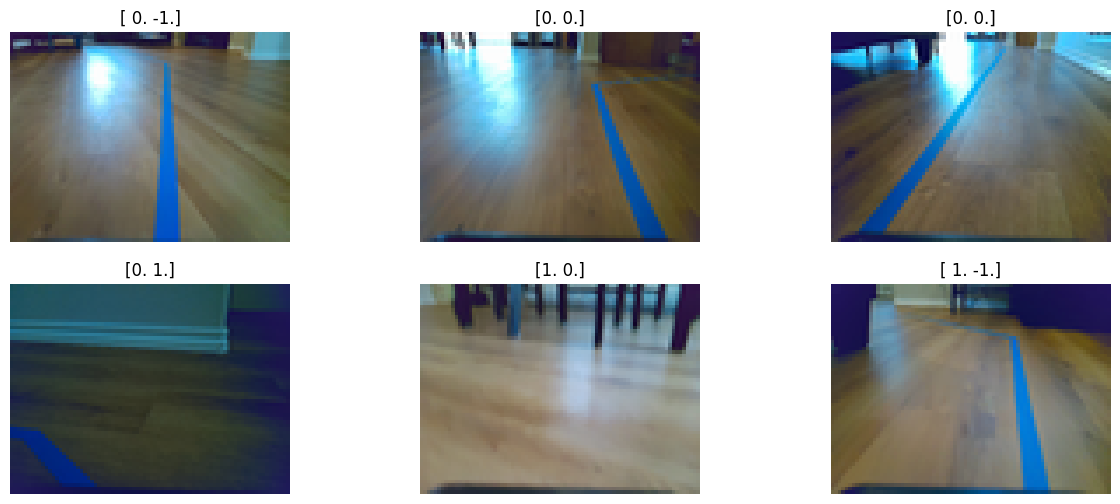

In [ ]:
# Plot a random 6 images and their labels
plt.figure(figsize=(15, 6))

for i in range(6):
  random_index = random.randint(0, len(images) - 1)

  ax = plt.subplot(2, 3, i + 1)
  plt.imshow(images[random_index])

  # Throttle, steering direction
  plt.title(labels[i])
  plt.axis("off")

plt.show()


Text(0.5, 1.0, 'Distribution of Steering Commands')

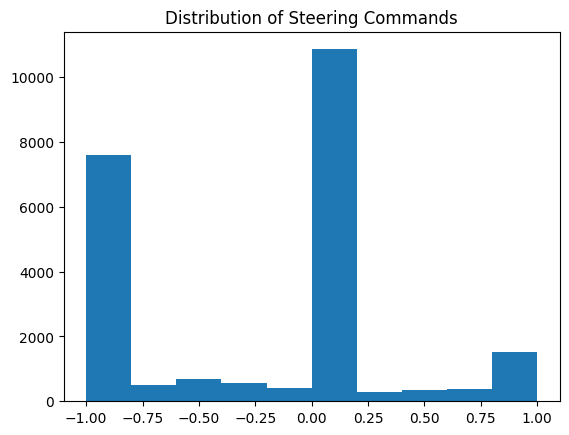

In [ ]:
import matplotlib.pyplot as plt

plt.hist(labels[:,1])
plt.title("Distribution of Steering Commands")

## Create Validation & Test Set


In [ ]:
SEED = 67
# Current split
# Train = 80%
# Val = 10%
# Test = 10%


X_train_img, X_temp_img, label_train, label_temp = train_test_split(
    images,
    labels,
    test_size=0.2,
    random_state=SEED
)

X_val_img, X_test_img, label_val, label_test = train_test_split(
    X_temp_img,
    label_temp,
    test_size=0.5,
    random_state=SEED
)

X_train_throttle = label_train[:,0]
X_val_throttle = label_val[:,0]
X_test_throttle = label_test[:,0]

Y_train = label_train[:,1]
Y_val = label_val[:,1]
Y_test = label_test[:,1]

In [ ]:
# Ensure this is a float32.

labels.dtype

dtype('float32')

## CNN

In [141]:
image_input = keras.Input(shape=(60, 80, 3))
x = layers.Conv2D(24, 5, padding='same', use_bias=False)(image_input)
x = layers.BatchNormalization(center=True, scale=False)(x)
x = layers.Activation('relu')(x)

x = layers.Conv2D(36, 5, strides=2, padding='same', use_bias=False)(x)
x = layers.BatchNormalization(center=True, scale=False)(x)
x = layers.Activation('relu')(x)

x = layers.Conv2D(48, 3, strides=2, padding='same', use_bias=False)(x)
x = layers.BatchNormalization(center=True, scale=False)(x)
x = layers.Activation('relu')(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)

throttle_on_input = keras.Input(shape=(1,))

# Concatenate features with throttle signal
x = layers.Concatenate()([x, throttle_on_input])


x = layers.Dense(64)(x)
x = layers.BatchNormalization(center=True, scale=False)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(24)(x)
x = layers.BatchNormalization(center=True, scale=False)(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.4)(x)

output = layers.Dense(1, activation='linear')(x)


model = keras.Model(inputs=[image_input, throttle_on_input], outputs=output)


In [ ]:
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 60, 80, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 60, 80,    │      1,800 │ input_layer_25[0… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 80,    │         72 │ conv2d_47[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_63       │ (None, 60, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 30, 40,    │     21,600 │ activation_63[0]… │
│                     │ 36)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 40,    │        108 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 36)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_64       │ (None, 30, 40,    │          0 │ batch_normalizat… │
│ (Activation)        │ 36)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 15, 20,    │     15,552 │ activation_64[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 20,    │        144 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_65       │ (None, 15, 20,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 48)        │          0 │ activation_65[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 48)        │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_26      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 49)        │          0 │ dropout_33[0][0], │
│ (Concatenate)       │                   │            │ input_layer_26[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 64)        │      3,200 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        192 │ dense_41[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_66       │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                 

 Total params: 44,325 (173.14 KB)

 Trainable params: 43,933 (171.61 KB)

 Non-trainable params: 392 (1.53 KB)

In [144]:

import math
def lr_decay(epoch):
    return 0.04 * math.pow(0.9, epoch)

lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

model.compile(optimizer='adam',
              loss=tf.keras.losses.Huber(delta=0.5),
              metrics=['mean_absolute_error'])

history = model.fit([X_train_img, X_train_throttle],
                    Y_train,
                    epochs=55,
                    batch_size=32,
                    validation_data=([X_val_img, X_val_throttle], Y_val),
                    callbacks=[lr_decay_callback]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.04.
Epoch 1/55
580/580 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.1437 - mean_absolute_error: 0.4781 - val_loss: 0.1524 - val_mean_absolute_error: 0.5189 - learning_rate: 0.0400

Epoch 2: LearningRateScheduler setting learning rate to 0.036000000000000004.
Epoch 2/55
580/580 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1069 - mean_absolute_error: 0.3872 - val_loss: 0.0872 - val_mean_absolute_error: 0.3422 - learning_rate: 0.0360

Epoch 3: LearningRateScheduler setting learning rate to 0.032400000000000005.
Epoch 3/55
580/580 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0919 - mean_absolute_error: 0.3450 - val_loss: 0.1324 - val_mean_absolute_error: 0.4321 - learning_rate: 0.0324

Epoch 4: LearningRateScheduler setting learning rate to 0.029160000000000005.
Epoch 4/55
580/580 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0854 - mean_absolute_error: 0.3299 - val_loss: 0.0767 - val_mean_absolute_error: 0.3243 - learning_rate: 0.0292

E

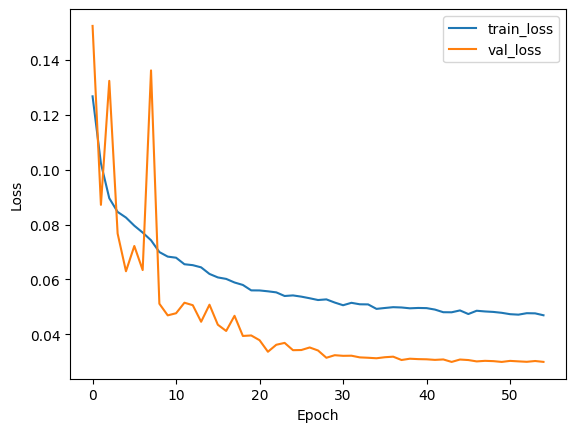

In [145]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [146]:
# Evaluate

mae = model.evaluate([X_test_img, X_test_throttle],  Y_test)

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0287 - mean_absolute_error: 0.1516


73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


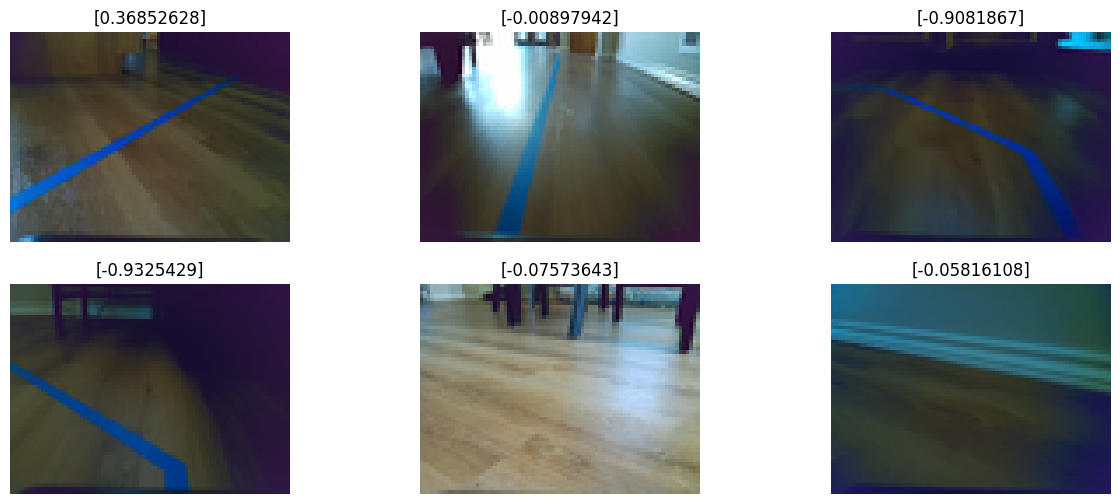

In [161]:
predictions = model.predict([X_test_img, X_test_throttle])
plt.figure(figsize=(15, 6))

for i in range(6):
  random_index = random.randint(0, len(X_test_img) - 1)
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow(X_test_img[random_index])

  # Throttle, steering direction
  plt.title(predictions[i])
  plt.axis("off")

plt.show()

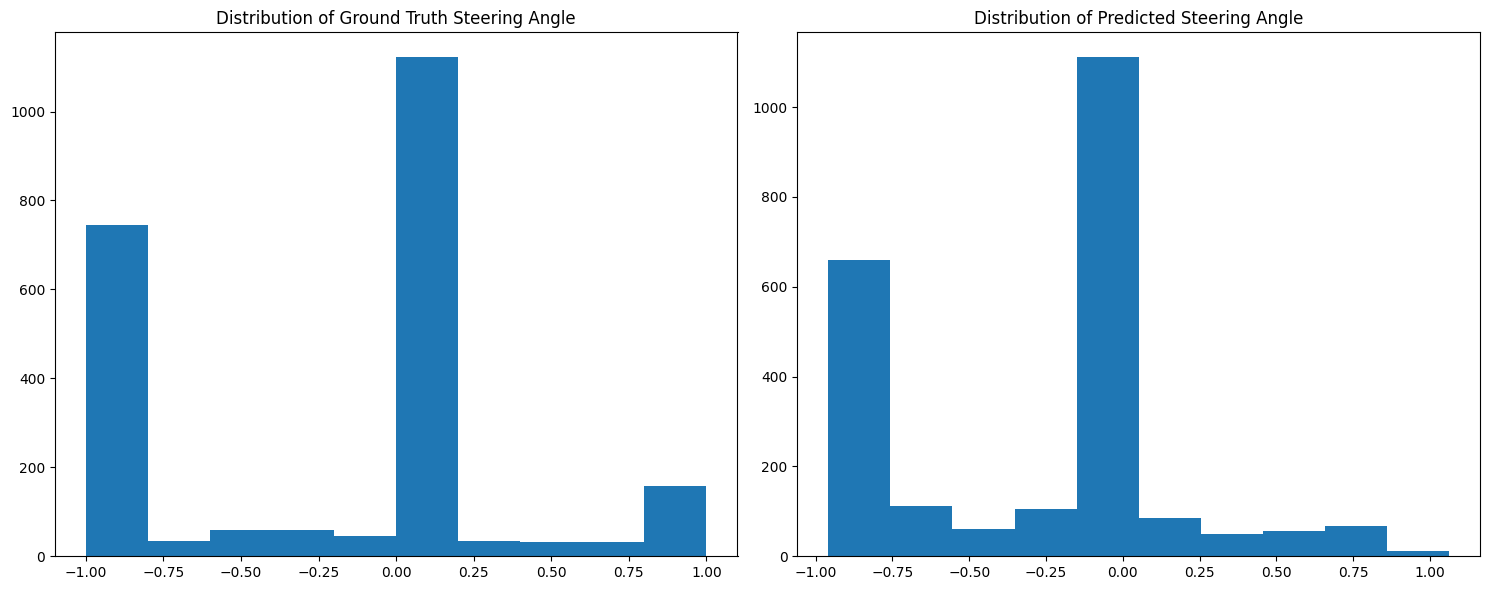

In [157]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax2.hist(predictions)
ax2.set_title("Distribution of Predicted Steering Angle")
ax1.hist(Y_test)
ax1.set_title("Distribution of Ground Truth Steering Angle")

plt.tight_layout()
plt.show()

In [ ]:
model.save("bc_car_model_full.h5")

## Prune and Quantize

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Results

In [ ]:
# Graphs, Confusion Matrix

## References

1.   

